# record test

In [1]:
import mxnet as mx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
f_name = '../cephfs/dataset/cifar/cifar-10-batches-py/batches.meta'
meta = unpickle(f_name)

FileNotFoundError: [Errno 2] No such file or directory: '../cephfs/dataset/cifar/cifar-10-batches-py/batches.meta'

In [11]:
label_name = meta[b'label_names']

In [20]:
data_iter = mx.io.ImageRecordIter(
    path_imgrec='../cephfs/dataset/cifar/cifar-10-val.rec',
    data_shape=(3, 224,224), 
    batch_size=4,
    resize=224
    )
data_iter.reset()
batch = data_iter.next()

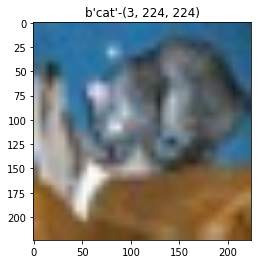

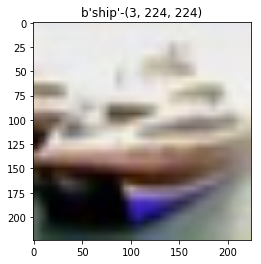

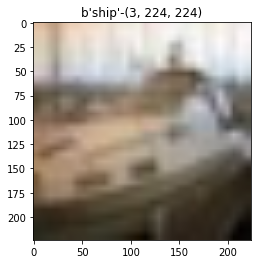

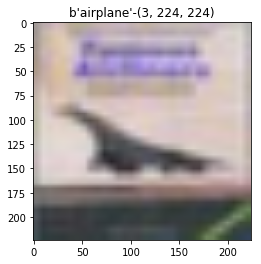

In [21]:
data = batch.data[0]
la = batch.label[0].asnumpy().astype(np.uint8).tolist()
for i in range(4):
    plt.figure(i)
    plt.title("{}-{}".format(label_name[la[i]],data[i].shape))
    plt.imshow(data[i].asnumpy().astype(np.uint8).transpose((1,2,0)))
plt.show()

# load checkpoint test

In [1]:
import mxnet as mx

In [5]:
sym, arg_params, aux_params = mx.model.load_checkpoint('../cephfs/model/vgg/vgg16', 0)

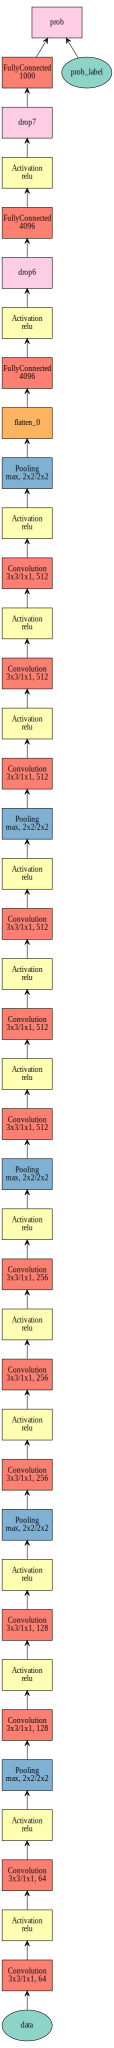

In [6]:
mx.viz.plot_network(sym)

In [5]:
def get_fine_tune_model(symbol, arg_params, num_classes, layer_name='flatten0'):
    """
    symbol: the pretrained network symbol
    arg_params: the argument parameters of the pretrained model
    num_classes: the number of classes for the fine-tune datasets
    layer_name: the layer name before the last fully-connected layer
    """
    all_layers = symbol.get_internals()
    net = all_layers[layer_name+'_output']
    net = mx.symbol.FullyConnected(data=net, num_hidden=num_classes, name='fc1')
    net = mx.symbol.SoftmaxOutput(data=net, name='softmax')
    new_args = dict({k:arg_params[k] for k in arg_params if 'fc1' not in k})
    return (net, new_args)

In [6]:
sym,args = get_fine_tune_model(sym,arg_params,10)

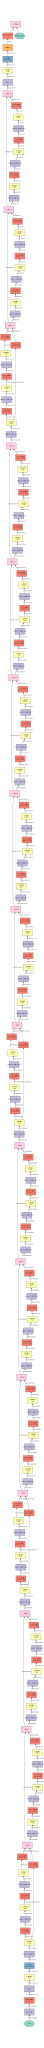

In [7]:
mx.viz.plot_network(sym,shape={"data":(128,3,224,224)})

# parser test

In [1]:
import argparse

In [10]:
parser = argparse.ArgumentParser(description='test')

In [11]:
parser.add_argument('-pre',type=str,default='de')

_StoreAction(option_strings=['-pre'], dest='pre', nargs=None, const=None, default='de', type=<class 'str'>, choices=None, help=None, metavar=None)

In [12]:
parser.parse_args([])

Namespace(pre='de')

# eval

In [1]:
import mxnet as mx
import os
import struct
import json
import numpy as np
import logging
import random
logging.getLogger().setLevel(logging.DEBUG)

In [2]:
val_path = '../cephfs/dataset/cifar/cifar-10-val.rec'
batch_size = 100
data_shape = (3,224,224)

In [3]:
val_iter = mx.io.ImageRecordIter(
        path_imgrec         = val_path,
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        resize              = 224,
        rand_crop           = False,
        rand_mirror         = False)

In [4]:
dev = [ mx.gpu(i) for i in [2,3]]

In [5]:
logs_dir = '../cephfs/logs/cifar/'
logs_names = os.listdir(logs_dir)

In [6]:
for name in logs_names:
    print("Start: ",name)
    model_path = os.path.join(logs_dir,name,'cifar')
    json_info = {}
    flag = True
    try:
        i = 0
        while flag and i < 50 :
            if (i+1) % 8 != 0:
                i += 1
                continue
            print('eval',i+1)
            sym,arg_params,aux_params = mx.model.load_checkpoint(model_path,i+1)
            arg_name = sym.list_arguments()
            mod = mx.mod.Module(symbol=sym, 
                            context=dev,
                            data_names = [arg_name[0]],
                            label_names = [arg_name[-1]]
                           )
            mod.bind(for_training=False,
                     data_shapes=val_iter.provide_data,
                     label_shapes=val_iter.provide_label)
            mod.set_params(arg_params,aux_params)
            metric = mx.metric.Accuracy()
            score = mod.score(val_iter, metric)
            json_info[i+1] = score
            print('score',score)
            i += 1
        print(name,"===>")
        print(json.dumps(json_info))
    except Exception as e:
        flag = False
#     output_file = os.path.join(logs_dir,name,'score.json')
#     f = open(output_file,'w')
#     f.write(json.dumps(json_info,indent=2))
#     f.close()

Start:  resnet-50_10_20181207T0052
eval 8
Start:  resnet-50_10_20181207T0957
eval 8
score [('accuracy', 0.9383)]
eval 16
score [('accuracy', 0.9422)]
eval 24
score [('accuracy', 0.9434)]
eval 32
score [('accuracy', 0.9455)]
eval 40
score [('accuracy', 0.943)]
eval 48
score [('accuracy', 0.9458)]
resnet-50_10_20181207T0957 ===>
{"8": [["accuracy", 0.9383]], "16": [["accuracy", 0.9422]], "24": [["accuracy", 0.9434]], "32": [["accuracy", 0.9455]], "40": [["accuracy", 0.943]], "48": [["accuracy", 0.9458]]}
Start:  resnet-50_10_20181207T0932
eval 8
Start:  20181206T1612
eval 8
Start:  resnet-50_10_20181206T1728
eval 8
Start:  resnet-50_10_20181206T1705
eval 8
